![CC-BY-SA](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-sa.svg)


This notebook was created by [Bernardo Freitas Paulo da Costa](http://www.im.ufrj.br/bernardofpc),
and is licensed under Creative Commons BY-SA.

Antes de enviar este Teste, verifique que tudo está funcionando como esperado.
Por exemplo, **rode o código inteiro, do zero**.
Para isso, vá no menu, escolha _Kernel_, depois _Restart & Run All_.

Verifique, também, que você respondeu todas as questões:
* as questões de código têm `YOUR CODE HERE` (e você pode apagar o `raise NotImplemented` ao incluir sua resposta)
* as questões discursivas têm "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Regressão periódica

## Dados

Nesta primeira parte iremos ajustar uma curva aos dados de demanda elétrica fornecidos pelo ONS,
para o período entre os dias *16.04.2018 - 16.05.2018*.

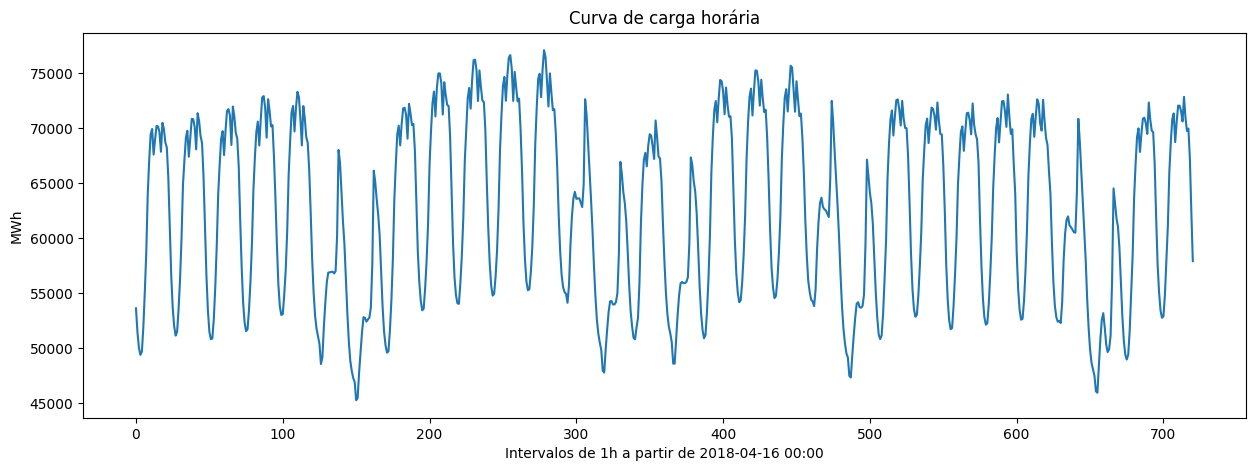

In [2]:
cch = np.load('Demanda_16.04.2018-16.05.2018.npz')
ys = cch['Demanda']
ts = np.arange(len(ys))

plt.figure(figsize=(15,5))
plt.plot(ts,ys)
plt.title("Curva de carga horária")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00");

Vamos pegar um intervalo com dias úteis.

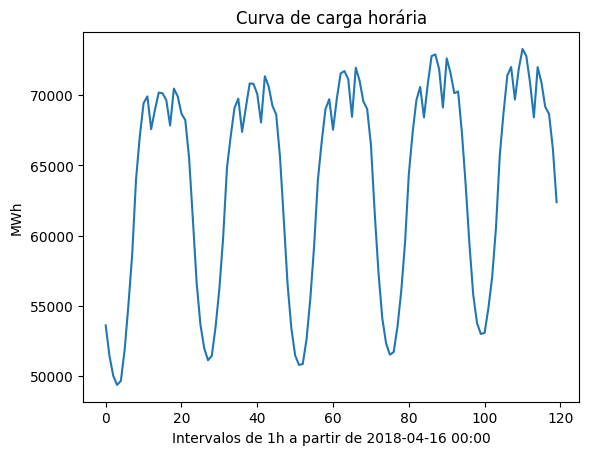

In [3]:
tmax = 120

plt.plot(ts[:tmax],ys[:tmax])
plt.title("Curva de carga horária")
plt.ylabel("MWh")
plt.xlabel("Intervalos de 1h a partir de 2018-04-16 00:00");

# Parte 1: Ajuste simples

## Questão 1: Matriz da regressão

O que salta aos olhos é o comportamento aproximadamente periódico,
logo uma primeira idéia é ajustar um modelo com funções também periódicas.

Um ajuste simples é o seguinte:
$$y(t) = c_0 + c_1\sin\left(\frac{2\pi t}{24}\right) + c_2\cos\left(\frac{2\pi t}{24}\right)$$

Explique porque o denominador 24 faz sentido para estes dados que temos.

Cada dia tem 24 horas. Colocando o denominador como 24, podemos fechar um período inteiro com um período de 24 unidades representando 24 horas, em t.

Escreva a função `make_trig_matrix(ts,p)`, que monta a matriz de regressão $X$ tal que $Xc = y$ para o modelo proposto acima para `ts` e com período `p`.

**Observações:**
- A função constante está na base;
- A ordem das colunas importa para os asserts (mas não para o ajuste, se você sabe o que faz).
  Assim, as colunas devem vir na ordem das funções: constante, seno, cosseno.

In [4]:
def make_trig_matrix(ts,p):
    """ Retorna a matriz de regressão para o modelo y(t) = c0 + c1*sin(2*pi*t/p) + c2*cos(2*pi*t/p). """
    ats = np.array(ts)
    return np.array([[1] * len(ats), np.sin(2*np.pi*ats/p), np.cos(2*np.pi*ats/p)]).transpose()

In [5]:
tss = np.linspace(-2*np.pi,2*np.pi,51)
X = make_trig_matrix(tss,np.pi)

assert all([np.isclose(X[i][0],1) for i in range(10)])

In [6]:
# Testes de periodicidade

assert np.allclose(X[0][1],X[-1][1])
assert np.allclose(X[0][1],X[len(tss)//2][1])
assert np.allclose(X[0][2],X[-1][2])
assert np.allclose(X[0][2],X[len(tss)//2][2])

## Questão 2: Gráficos

Faça o gráfico tanto dos dados como do ajuste do modelo,
usando apenas as 120 primeiras observações, que correspondem aos primeiros cinco dias úteis.

In [7]:
def make_reg_model(xs, ys, period=24):
    matriz_modelo = make_trig_matrix(xs, period)
    coefs, *_ = np.linalg.lstsq(matriz_modelo, ys, rcond=None)
    def p(x): 
        return coefs[0] + coefs[1]*np.sin(2*np.pi*x/period) + coefs[2]*np.cos(2*np.pi*x/period)
    return p

model = make_reg_model(ts[:tmax], ys[:tmax])
mys = model(ts[:tmax])

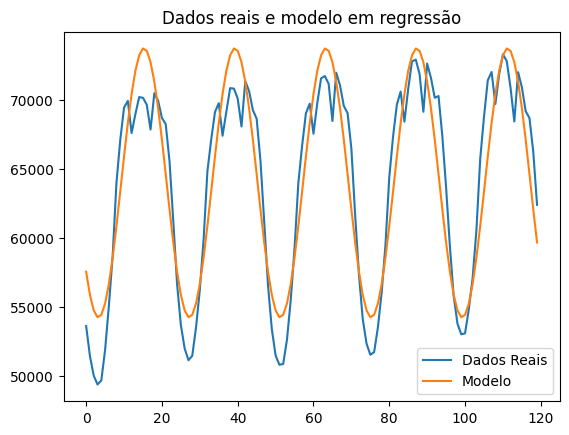

In [8]:
plt.plot(ts[:tmax], ys[:tmax], label="Dados Reais")
plt.plot(ts[:tmax], mys, label="Modelo")
plt.title("Dados reais e modelo em regressão")
plt.legend()

ax = plt.gca()
plt.show()

In [9]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

yss = [ax.lines[i].get_ydata() for i in range(2)]

assert 73000 <= np.max(yss) <= 73800
assert 49000 <= np.min(yss) <= 50000

In [10]:
ax = None

Plote também o residual (erro de ajuste)!

In [11]:
error = ys[:tmax] - mys

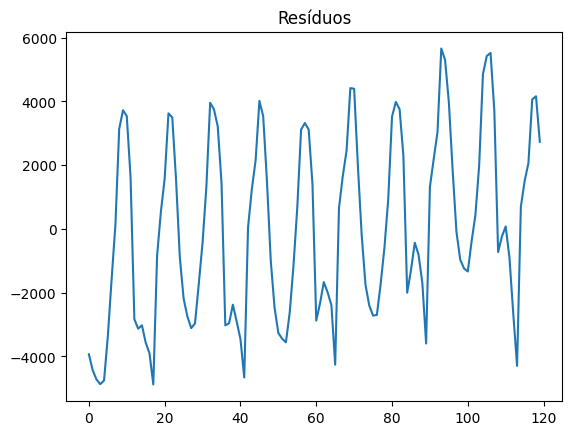

In [12]:
plt.plot(ts[:tmax], error)
plt.title("Resíduos")

ax = plt.gca()
plt.show()

In [13]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 1


In [14]:
ax = None

Esse gráfico reflete alguma tendência nos dados que difere do ajuste?
Se sim qual função poderia ser acrescentada a base do modelo para tentar capturar essa tendência?

Existe uma tendência de evolução do erro que é linear, com a inclinação positiva. Os erros, no início do período são mais concentrados para valores abaixo de zero e, no final do período, parece haver uma migração da concentração para valores acima de zero, ou mais próximos de zero.

Eu adicionaria uma função linear (do tipo $y = ax$) ao modelo, para capturar essa tendência.

O que mais você percebe no gráfico de erros?

Os erros também parecem ser periódicos, com o período de 24 horas, parecendo haver mais funções periódicas como parcelas do modelo.


## Questão 3: Uma base maior

Agora, vamos tentar um ajuste com mais funções periódicas (também ditas _harmônicas_):
$$y(t) = \alpha_0 +  \sum_{i=1}^k\alpha_i \sin\left(\frac{2\pi it}{24}\right) + \sum_{i=1}^k\beta_i \cos\left(\frac{2\pi it}{24}\right).$$

Para te auxiliar nessa tarefa escreva a função
- `make_full_trig_matrix(ts,p,k)`: Semelhante a `make_trig_matrix`, mas retorna a matriz para o ajuste acima,
  correspondente ao conjunto de harmônicos de $i=1$ até $i = k$.

In [15]:
def make_full_trig_matrix(ts,p,k):
    ats = np.array(ts)
    res = [[1] * len(ats)]
    for i in range(k):
        res += [np.sin(2*np.pi*(i+1)*ats/p)]
        res += [np.cos(2*np.pi*(i+1)*ats/p)]
    return np.array(res).transpose()

In [16]:
# Teste de sanidade
tss = np.arange(0,100)

X = make_full_trig_matrix(tss, 24, 1)
Y = make_trig_matrix(tss, 24)

for i in range(5):
    for j in range(3):
        assert np.isclose(X[i][j],Y[i][j])

In [17]:
# Teste de dimensão
tss = np.arange(0,100)

X = make_full_trig_matrix(tss, 24, 3)
assert np.shape(X) == (100,7)

## Questão 4: Gráficos de novo

Faça o gráfico do ajuste para $k = 2$, novamente para os 5 primeiros dias úteis.

In [18]:
def make_full_reg_model(xs, ys, k, period=24):
    matriz_modelo = make_full_trig_matrix(xs, period, k)
    coefs, *_ = np.linalg.lstsq(matriz_modelo, ys, rcond=None)
    def p(x): 
        res = coefs[0]
        for i in range(k):
            res = res + coefs[2*i+1]*np.sin(2*np.pi*(i+1)*x/period)
            res = res + coefs[2*i+2]*np.cos(2*np.pi*x*(i+1)/period)
        return res
    return p

full_model = make_full_reg_model(ts[:tmax], ys[:tmax], 2)
full_mys = full_model(ts[:tmax])

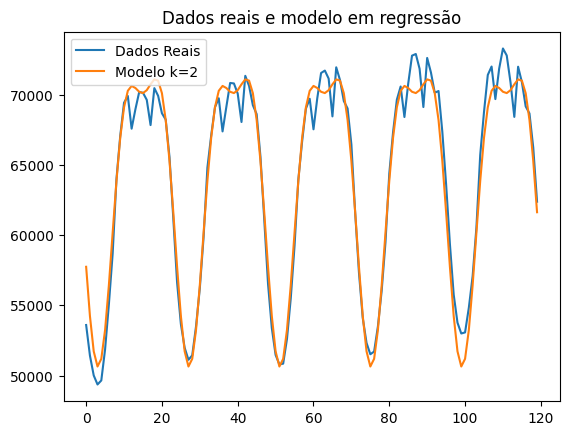

In [19]:
plt.plot(ts[:tmax], ys[:tmax], label="Dados Reais")
plt.plot(ts[:tmax], full_mys, label="Modelo k=2")
plt.title("Dados reais e modelo em regressão")
plt.legend()

ax = plt.gca()
plt.show()

In [20]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

for i in range(2):
    yss = ax.lines[i].get_ydata()
    assert 71000 <= np.max(yss) <= 73300
    assert 49000 <= np.min(yss) <= 51300

In [21]:
ax = None

E não se esqueça do residual.

In [22]:
full_error = ys[:tmax] - full_mys

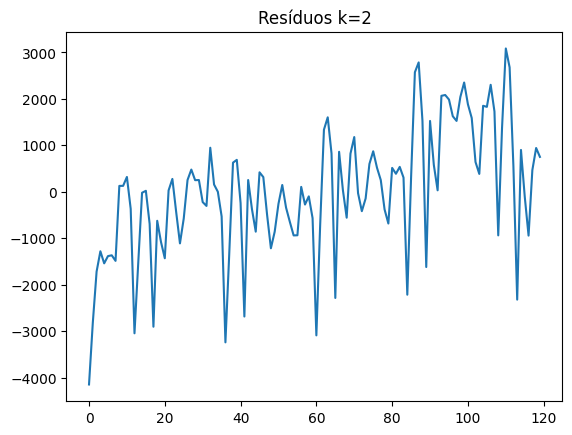

In [23]:
plt.plot(ts[:tmax], full_error)
plt.title("Resíduos k=2")

ax = plt.gca()
plt.show()

In [24]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 1


In [25]:
ax = None

Agora, faça o gráfico do erro para $k = 5$, $6$ e $10$, lado a lado.

**Dica:** Faça uma função `graph_err(k, tmax)` que faz o gráfico do erro do ajuste em função de `k` e `tmax`,
e use `subplot(1,3,j)` para selecionar o $j$-ésimo eixo.
(como é inspirada do MATLAB, essa função conta a partir de 1, não zero como padrão em python).

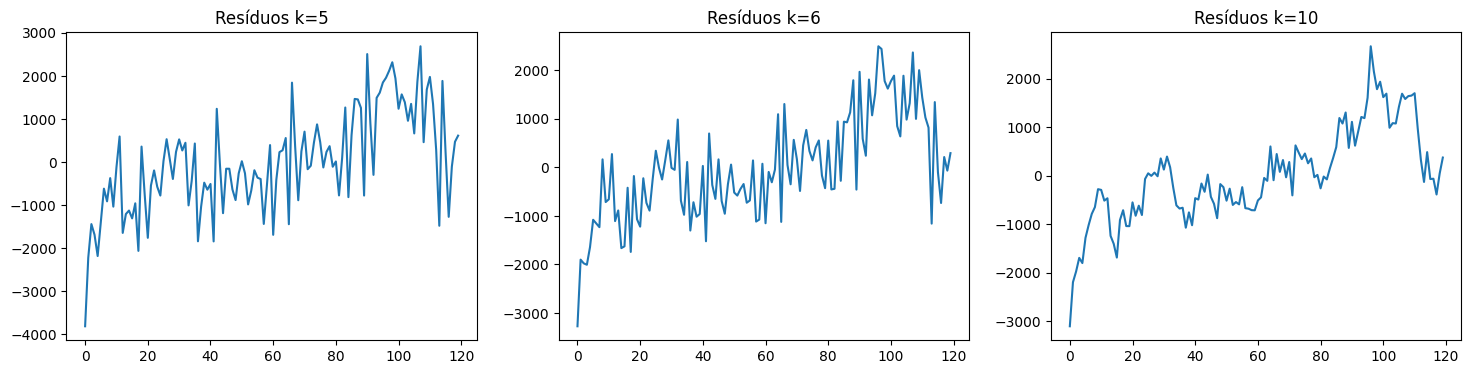

In [26]:
fig, axs = plt.subplots(ncols=3, figsize=(18,4))

def graph_err(k, tmax, j):
    f_model = make_full_reg_model(ts[:tmax], ys[:tmax], k)
    f_mys = f_model(ts[:tmax])
    l_error = ys[:tmax] - f_mys
    plt.subplot(1,3,j)
    plt.plot(ts[:tmax], l_error)
    plt.title("Resíduos k={}".format(k))

ks = [5, 6, 10]
for i in range(len(ks)):
    graph_err(ks[i], tmax, i+1)

plt.show()

O que você muda e o que não muda ao aumentar $k$?

É visível que, a medida que o $k$ aumenta, o erro vai se achatando em direção a zero e a curva de erro se torna mais suave, ou seja, com menos saltos e com menos variações. Entretanto, a tendência linear de subida do erro (de valores negativos, para valores positivos) se mantém, deixando claro que uma parcela linear é claramente necessária no modelo.

# Parte 2: Ajuste misto

## Questão 5: Polinômios e funções trigonométricas

Vamos adicionar polinômios à base, e comparar o erro de regressão obtido com uma base um pouco maior.

Comece implementando a função `make_poly_matrix(ts, d_max)`,
que retorna a matriz de ajuste polinomial de grau até $d_\max$.

Para não duplicar a coluna de 1's na matriz do modelo completo,
a função `make_poly_matrix` não retorna a coluna correspondente às funções constantes,
mas apenas aos polinômios $X$, $X^2$, ..., $X^{d_\max}$.

In [27]:
def make_poly_matrix(ts, dmax):
    assert dmax >= 1
    return np.array([np.power(ts, i+1) for i in range(dmax)]).transpose()

In [28]:
tss = np.arange(1,5)

X = make_poly_matrix(tss,3)

assert np.allclose(X[0],[1,1,1])
assert np.allclose(X[1],[2,4,8])
assert np.allclose(X[2],[3,9,27])
assert np.allclose(X[3],[4,16,64])

Agora, faça uma função que retorna a matriz do ajuste misto

In [29]:
def make_trig_poly(ts, p, k, dmax):
    if dmax == 0:
        return make_full_trig_matrix(ts, p, k)
    else:
        return np.concatenate((make_full_trig_matrix(ts, p, k),make_poly_matrix(ts, dmax)),axis=1)

## Questão 6: Mais gráficos ainda

Trace, num mesmo eixo, os erros correspondentes aos seguintes ajustes:
- Trigonométrico original, com apenas 1 harmônico
- Trigonométrico com 6 harmônicos
- Misto com 1 harmônico e um polinômio de grau 1
- Misto com 6 harmônicos e polinômio de grau 1
- Misto com 1 harmônico e polinômios de grau até 5
- Misto com 6 harmônicos e polinômios de grau até 5

In [30]:
def make_trig_poly_reg_model(xs, ys, k, period, dmax):
    matriz_modelo = make_trig_poly(xs, period, k, dmax)
    coefs, *_ = np.linalg.lstsq(matriz_modelo, ys, rcond=None)
    def p(x): 
        res = coefs[0]
        for i in range(k):
            res = res + coefs[2*i+1]*np.sin(2*np.pi*(i+1)*x/period)
            res = res + coefs[2*i+2]*np.cos(2*np.pi*x*(i+1)/period)
        for i in range(dmax):
            res = res + coefs[2*k + i + 1]*np.power(x, i + 1)
        return res
    return p

In [31]:
def graph_err(ts, ys, p, k, dmax):
    """Função auxiliar para gráfico de erros"""
    # f_model = make_full_reg_model(ts, ys, k)
    f_model = make_trig_poly_reg_model(ts, ys, k, p, dmax)
    f_mys = f_model(ts)
    l_error = ys - f_mys
    plt.plot(ts, l_error, label="Resíduo para k={}, dmax={}".format(k, dmax))
    plt.title("Apresentação de Resíduos para vários aproximações")
    plt.legend()

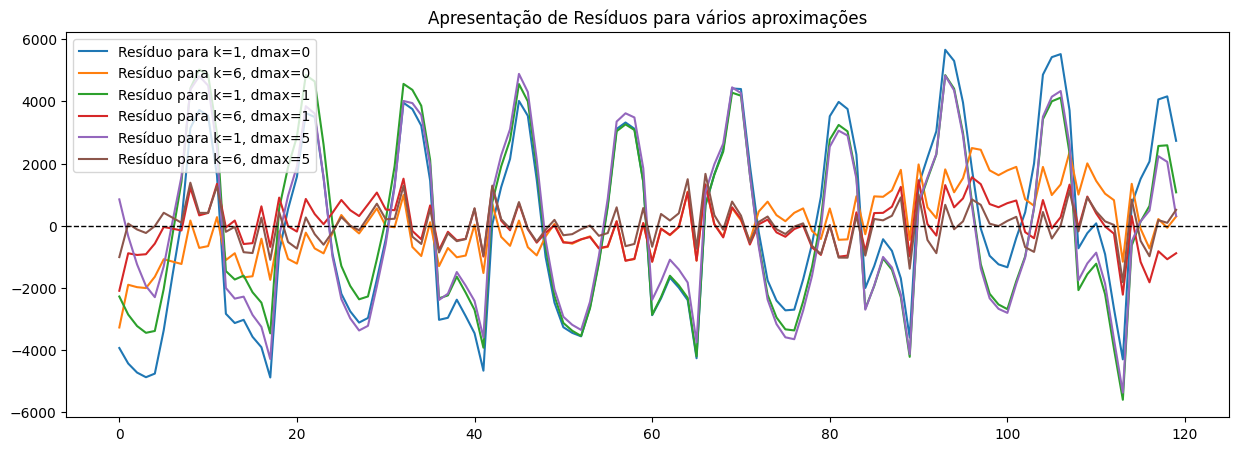

In [32]:
plt.figure(figsize=(15,5))

subts = ts[:120]
subys = ys[:120]

graph_err(subts, subys, 24, 1, 0)
graph_err(subts, subys, 24, 6, 0)
graph_err(subts, subys, 24, 1, 1)
graph_err(subts, subys, 24, 6, 1)
graph_err(subts, subys, 24, 1, 5)
graph_err(subts, subys, 24, 6, 5)

plt.axhline(color='black', linestyle='--', linewidth=1)
ax = plt.gca()
plt.show()

In [33]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 7
assert len(ax.legend().texts) == 6

O que você observou? Que melhora é obtida com o acréscimo dos polinômios da base?

Com a adição dos polinômios a gente elimina o erro não periódico, que segue a tendência de aumentar na medida em que o valor de t aumenta, ou seja, a inclinação média dos erros deixa de ser positiva e se aproxima de zero.

Faça agora dois gráficos de erro, para separar em dois grupos.

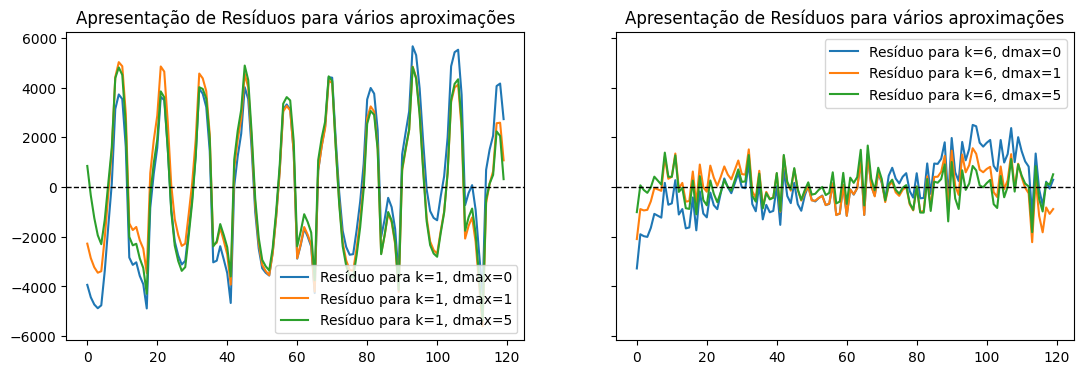

In [34]:
fig, axs = plt.subplots(ncols=2, figsize=(13,4), sharey=True)

subts = ts[:120]
subys = ys[:120]

plt.subplot(1,2,1)
graph_err(subts, subys, 24, 1, 0)
graph_err(subts, subys, 24, 1, 1)
graph_err(subts, subys, 24, 1, 5)
plt.axhline(color='black', linestyle='--', linewidth=1)

plt.subplot(1,2,2)
graph_err(subts, subys, 24, 6, 0)
graph_err(subts, subys, 24, 6, 1)
graph_err(subts, subys, 24, 6, 5)
plt.axhline(color='black', linestyle='--', linewidth=1)
ax = plt.gca()
plt.show()

- Quais são os grupos que você escolheu?
- Porquê?

Os grupos escolhidos foram aquelas regressões em que os resíduos têm comportamento periódico e as regressões em que os resíduos têm comportamento são períodico, quase-constante.

O primeiro grupo é aquele em que as regressões trigonométricas são de um grau reduzido, não havendo o melhor ajuste períodico para as séries de dados, enquanto o segundo grupo é aquele em que as regressões trigonométricas são de grau mais elevado, havendo melhor ajuste períódico para as séries de dados.

Os ajustes polinomiais parecem não influenciar nas frequências dos erros.